<a href="https://colab.research.google.com/github/Nikita018/Semantic-Segmentation-Suite/blob/master/InceptionDeepNet-21/03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mouting google drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd '/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite'

/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite


In [3]:
import os, csv, random, time, datetime, cv2
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from utils import utils,helpers


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



0001TP_006690_L.png


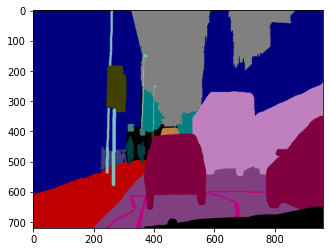

In [45]:
files=os.listdir(os.getcwd())
print(files[0])
img=cv2.imread(files[0])
plt.imshow(img)
plt.show()

In [0]:
def get_label_info(csv_path):
    """
    Retrieve the class names and label values for the selected dataset.
    Must be in CSV format!
    # Arguments
        csv_path: The file path of the class dictionairy
        
    # Returns
        Two lists: one for the class names and the other for the label values
    """
    filename, file_extension = os.path.splitext(csv_path)
    if not file_extension == ".csv":
        return ValueError("File is not a CSV!")

    class_names = []
    label_values = []
    with open(csv_path, 'r') as csvfile:
        file_reader = csv.reader(csvfile, delimiter=',')
        header = next(file_reader)
        for row in file_reader:
            class_names.append(row[0])
            label_values.append([int(row[1]), int(row[2]), int(row[3])])
        # print(class_dict)
    return class_names, label_values


In [0]:
# Get the names of the classes so we can record the evaluation results
class_names_list, label_values = get_label_info(os.path.join('/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/CamVid/class_dict.csv'))
class_names_string = ""
for class_name in class_names_list:
    if not class_name == class_names_list[-1]:
        class_names_string = class_names_string + class_name + ", "
    else:
        class_names_string = class_names_string + class_name



In [0]:
dataset_dir="CamVid"

def prepare_data(dataset_dir):
    train_input_names=[]
    train_output_names=[]
    val_input_names=[]
    val_output_names=[]
    test_input_names=[]
    test_output_names=[]
    for file in os.listdir(dataset_dir + "/train"):
        cwd = os.getcwd()
        train_input_names.append(cwd + "/" + dataset_dir + "/train/" + file)
    for file in os.listdir(dataset_dir + "/train_labels"):
        cwd = os.getcwd()
        train_output_names.append(cwd + "/" + dataset_dir + "/train_labels/" + file)
    for file in os.listdir(dataset_dir + "/val"):
        cwd = os.getcwd()
        val_input_names.append(cwd + "/" + dataset_dir + "/val/" + file)
    for file in os.listdir(dataset_dir + "/val_labels"):
        cwd = os.getcwd()
        val_output_names.append(cwd + "/" + dataset_dir + "/val_labels/" + file)
    for file in os.listdir(dataset_dir + "/test"):
        cwd = os.getcwd()
        test_input_names.append(cwd + "/" + dataset_dir + "/test/" + file)
    for file in os.listdir(dataset_dir + "/test_labels"):
        cwd = os.getcwd()
        test_output_names.append(cwd + "/" + dataset_dir + "/test_labels/" + file)
    train_input_names.sort(),train_output_names.sort(), val_input_names.sort(), val_output_names.sort(), test_input_names.sort(), test_output_names.sort()
    return train_input_names,train_output_names, val_input_names, val_output_names, test_input_names, test_output_names

train_input_names,train_output_names, val_input_names, val_output_names, test_input_names, test_output_names = prepare_data(dataset_dir)

In [0]:
input_image_batch = []
output_image_batch = []
batch_size=10
i=1
id_list = np.random.permutation(len(train_input_names))
# Collect a batch of images
for j in range(batch_size):
    index = i*batch_size + j
    id = id_list[index]
    input_image = utils.load_image(train_input_names[id])
    output_image = utils.load_image(train_output_names[id])

    with tf.device('/cpu:0'):
        input_image = np.float32(input_image) / 255.0
        output_image = np.float32(helpers.one_hot_it(label=output_image, label_values=label_values))

        input_image_batch.append(np.expand_dims(input_image, axis=0))
        output_image_batch.append(np.expand_dims(output_image, axis=0))

if batch_size == 1:
    input_image_batch = input_image_batch[0]
    output_image_batch = output_image_batch[0]
else:
    input_image_batch = np.squeeze(np.stack(input_image_batch, axis=1))
    output_image_batch = np.squeeze(np.stack(output_image_batch, axis=1))

In [23]:

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (720, 960, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
print(last_output)
inputs = last_output
feature_map_size = tf.shape(last_output)
depth=256
label_size = tf.shape(inputs)[1:3]

num_classes = 32

# Global average pooling
image_features = tf.reduce_mean(inputs, [1, 2], keep_dims=True)
print(image_features)


image_features = tf.keras.layers.Conv2D(
    depth, [1, 1], strides=(1, 1), activity_regularizer=None
)(image_features)

image_features = tf.image.resize_bilinear(image_features, (feature_map_size[1], feature_map_size[2]))

atrous_pool_block_1 = tf.keras.layers.Conv2D(depth, [1, 1], strides=(1, 1), activity_regularizer=None)(inputs)

atrous_pool_block_6 = tf.keras.layers.Conv2D(depth, [3, 3], padding = 'same', dilation_rate = [6,6],activity_regularizer=None)(inputs)

atrous_pool_block_12 = tf.keras.layers.Conv2D(depth, [3, 3], padding = 'same', dilation_rate = [12,12],activity_regularizer=None)(inputs)

atrous_pool_block_18 = tf.keras.layers.Conv2D(depth, [3, 3], padding = 'same', dilation_rate = [18,18],activity_regularizer=None)(inputs)

net = tf.concat((image_features, atrous_pool_block_1, atrous_pool_block_6, atrous_pool_block_12, atrous_pool_block_18), axis=3)
net = tf.keras.layers.Conv2D(depth, [1, 1], activity_regularizer=None)(net)
net = tf.image.resize_bilinear(net, size=label_size)
net = tf.keras.layers.Conv2D(num_classes, [1, 1], activity_regularizer=None)(net)
model = Model( net)
#model.summary() 

--2020-03-21 19:39:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   186MB/s    in 0.5s    

2020-03-21 19:39:43 (186 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 43, 58, 768)
Tensor("mixed7_3/concat:0", shape=(?, 43, 58, 768), dtype=float32)
Tensor("Mean_3:0", shape=(?, 1, 1, 768), dtype=float32)


In [17]:
model.outputs

[<tf.Tensor 'conv2d_100/BiasAdd:0' shape=(?, ?, ?, 32) dtype=float32>]

In [22]:
# Compute your softmax cross entropy loss
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.preprocessing.image import ImageDataGenerator

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
history = model.fit(
      input_image_batch, output_image_batch,
      steps_per_epoch=8,  
      epochs=1,
      verbose=1)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8 samples


InvalidArgumentError: ignored

In [10]:
import random
print("\n***** Begin training *****")
avg_loss_per_epoch = []
avg_scores_per_epoch = []
avg_iou_per_epoch = []

# Which validation images do we want
val_indices = []
num_vals = min(20, len(val_input_names))

# Set random seed to make sure models are validated on the same validation images.
# So you can compare the results of different models more intuitively.
random.seed(16)
val_indices=random.sample(range(0,len(val_input_names)),num_vals)


***** Begin training *****


In [0]:
def load_image(path):
    image = cv2.cvtColor(cv2.imread(path,-1), cv2.COLOR_BGR2RGB)
    return image

def one_hot_it(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    # st = time.time()
    # w = label.shape[0]
    # h = label.shape[1]
    # num_classes = len(class_dict)
    # x = np.zeros([w,h,num_classes])
    # unique_labels = sortedlist((class_dict.values()))
    # for i in range(0, w):
    #     for j in range(0, h):
    #         index = unique_labels.index(list(label[i][j][:]))
    #         x[i,j,index]=1
    # print("Time 1 = ", time.time() - st)

    # st = time.time()
    # https://stackoverflow.com/questions/46903885/map-rgb-semantic-maps-to-one-hot-encodings-and-vice-versa-in-tensorflow
    # https://stackoverflow.com/questions/14859458/how-to-check-if-all-values-in-the-columns-of-a-numpy-matrix-are-the-same
    semantic_map = []
    for colour in label_values:
        # colour_map = np.full((label.shape[0], label.shape[1], label.shape[2]), colour, dtype=int)
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    # print("Time 2 = ", time.time() - st)

    return semantic_map

def LOG(X, f=None):
    time_stamp = datetime.datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
    if not f:
        print(time_stamp + " " + X)
    else:
        f.write(time_stamp + " " + X)

def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    # w = image.shape[0]
    # h = image.shape[1]
    # x = np.zeros([w,h,1])

    # for i in range(0, w):
    #     for j in range(0, h):
    #         index, value = max(enumerate(image[i, j, :]), key=operator.itemgetter(1))
    #         x[i, j] = index

    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values
        
    # Returns
        Colour coded image for segmentation visualization
    """
    
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x


In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.Session(config=config)


In [28]:
# Do the training here
num_epochs = 2
batch_size = 10
for epoch in range(0, num_epochs):

    current_losses = []

    cnt=0

    # Equivalent to shuffling
    id_list = np.random.permutation(len(train_input_names))

    num_iters = int(np.floor(len(id_list) / batch_size))
    st = time.time()
    epoch_st=time.time()
    for i in range(num_iters):
        # st=time.time()
        input_image_batch = []
        output_image_batch = []

        # Collect a batch of images
        for j in range(batch_size):
            index = i*batch_size + j
            id = id_list[index]
            input_image = load_image(train_input_names[id])
            output_image = load_image(train_output_names[id])

            with tf.device('/cpu:0'):
                #input_image, output_image = data_augmentation(input_image, output_image)


                # Prep the data. Make sure the labels are in one-hot format
                input_image = np.float32(input_image) / 255.0
                output_image = np.float32(one_hot_it(label=output_image, label_values=label_values))

                input_image_batch.append(np.expand_dims(input_image, axis=0))
                output_image_batch.append(np.expand_dims(output_image, axis=0))

        if batch_size == 1:
            input_image_batch = input_image_batch[0]
            output_image_batch = output_image_batch[0]
        else:
            input_image_batch = np.squeeze(np.stack(input_image_batch, axis=1))
            output_image_batch = np.squeeze(np.stack(output_image_batch, axis=1))

        # Do the training
        _,current=sess.run([opt,loss],feed_dict={net_input:input_image_batch,net_output:output_image_batch})
        current_losses.append(current)
        cnt = cnt + batch_size
        if cnt % 20 == 0:
            string_print = "Epoch = %d Count = %d Current_Loss = %.4f Time = %.2f"%(epoch,cnt,current,time.time()-st)
            LOG(string_print)
            st = time.time()

    mean_loss = np.mean(current_losses)
    avg_loss_per_epoch.append(mean_loss)

    # Create directories if needed
    if not os.path.isdir("%s/%04d"%("checkpoints",epoch)):
        os.makedirs("%s/%04d"%("checkpoints",epoch))

    # Save latest checkpoint to same file name
    print("Saving latest checkpoint")
    saver.save(sess,model_checkpoint_name)

    checkpoint_step = 5
    validation_step = 1

    if val_indices != 0 and epoch % checkpoint_step == 0:
        print("Saving checkpoint for this epoch")
        saver.save(sess,"%s/%04d/model.ckpt"%("checkpoints",epoch))


    if epoch % validation_step == 0:
        print("Performing validation")
        target=open("%s/%04d/val_scores.csv"%("checkpoints",epoch),'w')
        target.write("val_name, avg_accuracy, precision, recall, f1 score, mean iou, %s\n" % (class_names_string))


        scores_list = []
        class_scores_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        iou_list = []


        # Do the validation on a small set of validation images
        for ind in val_indices:

            # input_image = np.expand_dims(np.float32(utils.load_image(val_input_names[ind])[:args.crop_height, :args.crop_width]),axis=0)/255.0
            # gt = utils.load_image(val_output_names[ind])[:args.crop_height, :args.crop_width]
            gt = reverse_one_hot(one_hot_it(gt, label_values))

            # st = time.time()

            output_image = sess.run(network,feed_dict={net_input:input_image})


            output_image = np.array(output_image[0,:,:,:])
            output_image = reverse_one_hot(output_image)
            out_vis_image = colour_code_segmentation(output_image, label_values)

            accuracy, class_accuracies, prec, rec, f1, iou = utils.evaluate_segmentation(pred=output_image, label=gt, num_classes=num_classes)

            file_name = utils.filepath_to_name(val_input_names[ind])
            target.write("%s, %f, %f, %f, %f, %f"%(file_name, accuracy, prec, rec, f1, iou))
            for item in class_accuracies:
                target.write(", %f"%(item))
            target.write("\n")

            scores_list.append(accuracy)
            class_scores_list.append(class_accuracies)
            precision_list.append(prec)
            recall_list.append(rec)
            f1_list.append(f1)
            iou_list.append(iou)

            gt = helpers.colour_code_segmentation(gt, label_values)

            file_name = os.path.basename(val_input_names[ind])
            file_name = os.path.splitext(file_name)[0]
            cv2.imwrite("%s/%04d/%s_pred.png"%("checkpoints",epoch, file_name),cv2.cvtColor(np.uint8(out_vis_image), cv2.COLOR_RGB2BGR))
            cv2.imwrite("%s/%04d/%s_gt.png"%("checkpoints",epoch, file_name),cv2.cvtColor(np.uint8(gt), cv2.COLOR_RGB2BGR))


        target.close()

        avg_score = np.mean(scores_list)
        class_avg_scores = np.mean(class_scores_list, axis=0)
        avg_scores_per_epoch.append(avg_score)
        avg_precision = np.mean(precision_list)
        avg_recall = np.mean(recall_list)
        avg_f1 = np.mean(f1_list)
        avg_iou = np.mean(iou_list)
        avg_iou_per_epoch.append(avg_iou)

        print("\nAverage validation accuracy for epoch # %04d = %f"% (epoch, avg_score))
        print("Average per class validation accuracies for epoch # %04d:"% (epoch))
        for index, item in enumerate(class_avg_scores):
            print("%s = %f" % (class_names_list[index], item))
        print("Validation precision = ", avg_precision)
        print("Validation recall = ", avg_recall)
        print("Validation F1 score = ", avg_f1)
        print("Validation IoU score = ", avg_iou)

    epoch_time=time.time()-epoch_st
    remain_time=epoch_time*(num_epochs-1-epoch)
    m, s = divmod(remain_time, 60)
    h, m = divmod(m, 60)
    if s!=0:
        train_time="Remaining training time = %d hours %d minutes %d seconds\n"%(h,m,s)
    else:
        train_time="Remaining training time : Training completed.\n"
    LOG(train_time)
    scores_list = []


    fig1, ax1 = plt.subplots(figsize=(11, 8))

    ax1.plot(range(epoch+1), avg_scores_per_epoch)
    ax1.set_title("Average validation accuracy vs epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Avg. val. accuracy")


    plt.savefig('accuracy_vs_epochs.png')

    plt.clf()

    fig2, ax2 = plt.subplots(figsize=(11, 8))

    ax2.plot(range(epoch+1), avg_loss_per_epoch)
    ax2.set_title("Average loss vs epochs")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Current loss")

    plt.savefig('loss_vs_epochs.png')

    plt.clf()

    fig3, ax3 = plt.subplots(figsize=(11, 8))

    ax3.plot(range(epoch+1), avg_iou_per_epoch)
    ax3.set_title("Average IoU vs epochs")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Current IoU")

    plt.savefig('iou_vs_epochs.png')

NameError: ignored